  0%|          | 0/722 [00:00<?, ?it/s]

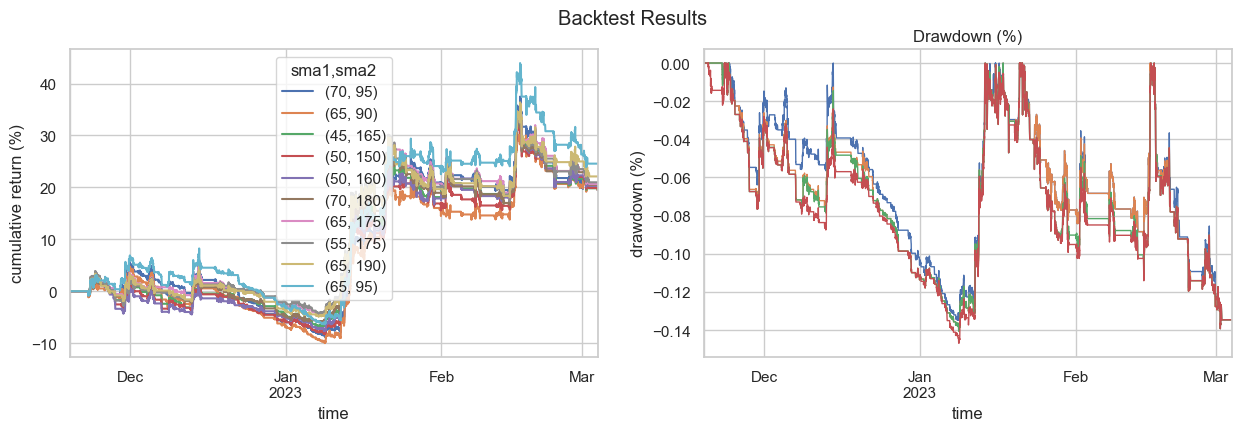

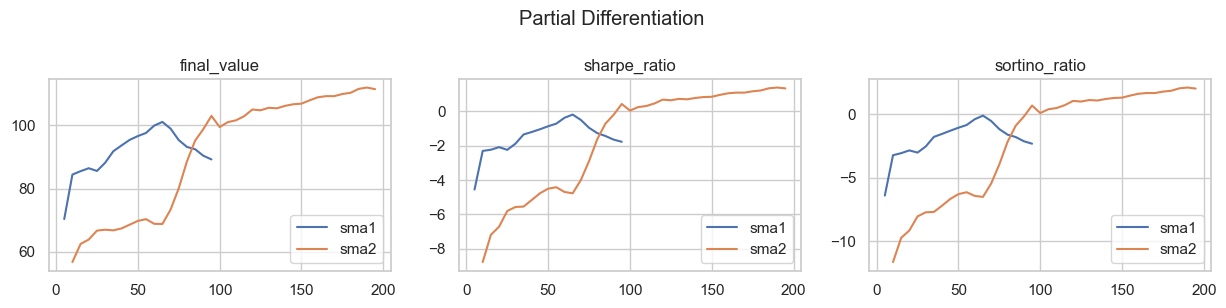

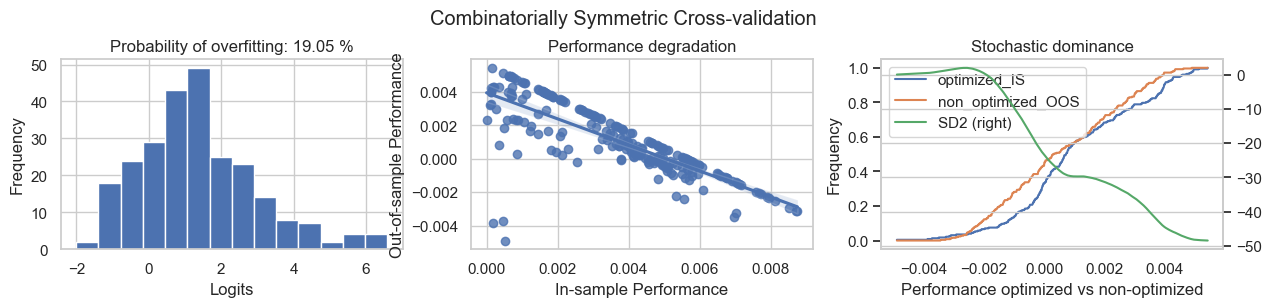

Output()

('PASS', 65, 95)

In [20]:
from tokens import api_key,api_secret,apiToken,chatID
from binance import Client
import finlab_crypto
from finlab_crypto import Strategy
import numpy as np
import pandas as pd

# 建立客戶端
client = Client(api_key=api_key,api_secret=api_secret)

# 定義漲跌訊號函數
def get_signal(
      pair='BTCUSDT',
      freq='15m',
      n_bar = 10000,
      client = client
      ):
  # get the pair ohlcv data
  ohlcv = finlab_crypto.crawler.get_nbars_binance(pair,freq,n_bar,client)
  
  # def base sma_Strategy
  @Strategy(sma1=20, sma2=60)
  def sma_strategy(ohlcv):
    close = ohlcv.close
    # crete sma1 and sma2
    sma1 = close.rolling(sma_strategy.sma1).mean()
    sma2 = close.rolling(sma_strategy.sma2).mean()
    # def entries and exits
    entries = (sma1 > sma2) & (sma1.shift() < sma2.shift())
    exits = (sma1 < sma2) & (sma1.shift() > sma2.shift())
    figures = {'overlaps': {'sma1': sma1,'sma1': sma2}}
    return entries, exits, figures
  
  # search range
  variables = {
      'sma1': np.arange(5, 100, 5), 
      'sma2': np.arange(10, 200, 5),
      }
  
  # sma_strategy.backtest
  portfolio = sma_strategy.backtest(ohlcv, variables=variables, freq=freq ,plot=True)
  # find portfolio.total_profit().max()
  temp = portfolio.total_profit()[portfolio.total_profit()==portfolio.total_profit().max()].to_frame().reset_index()
  # find portfolio.total_profit().max() use n1 and n2
  n1,n2 = temp['sma1'].values[0],temp['sma2'].values[0]
  
  # create signal table
  table = pd.DataFrame()
  table['close'] = ohlcv.close
  table['n1'] = ohlcv.close.rolling(n1).mean()
  table['n2'] = ohlcv.close.rolling(n2).mean()
  table['buy'] = ((table['n1'] > table['n2']) & (table['n1'].shift() < table['n2'].shift())).astype(int)
  table['sell'] = ((table['n1'] < table['n2']) & (table['n1'].shift() > table['n2'].shift())).astype(int)
  # get last row of the table
  table = table.replace(0,np.nan).tail(1)
  # if buy and sell eqal np.nan pass
  if table[['buy','sell']].sum().sum() == 0:
     signal = 'PASS'
  # if buy == 1
  if table[['buy']].values[0][0] == 1:
     signal = 'BUY'
  # if sell == 1
  if table[['sell']].values[0][0] == 1:
     signal = 'SELL'
  return signal,n1,n2

get_signal(
      pair='BTCUSDT',
      freq='15m',
      n_bar = 10000,
      client = client
      )